generating multitask sample data
computing optimizer of full problem


/Users/samsonkoelle/miniconda3/envs/montlake_xxx/lib/python3.6/site-packages/cvxpy/problems/problem.py:1303: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


reconstruction constraint and loss 9.949958388740659e-16 17.868875205104658
many coefficients are close to 0
sparsity is shared across tasks
enforece sparsity following I selected a number here following https://github.com/cvxpy/cvxpy/blob/master/examples/notebooks/WWW/sparse_solution.ipynb
sparse reconstruction constraint and loss 2.8629063102538607e-15 17.868875205104622
refitting with only retained coefficients
sparse refit reconstruction constraint and penalty 1.3190391034620074e-12 17.868875206447616
it looks like the refit solution has better constraint satisfaction and lower loss than the original solution!


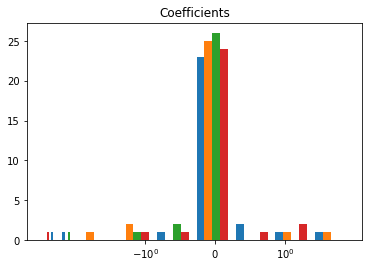

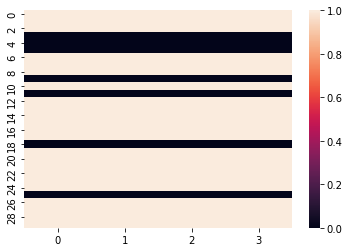

In [79]:
# what is rank of retained functions?
import numpy as np
from einops import rearrange
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns

print('generating multitask sample data')
np.random.seed(42)
n = 1
d = 4
p = 30
sample_grads = .1* np.random.multivariate_normal(np.zeros(d), np.identity(d),p)
X = rearrange(sample_grads, 'p d -> d p')
y= np.identity(d)

print('computing optimizer of full problem')
beta = cp.Variable((p,d))
objective = cp.Minimize(cp.sum(cp.norm(beta, axis = 1)))
constraints = [X @ beta == y]
problem = cp.Problem(objective, constraints)
# result = problem.solve(reltol=1e-14)
scs_opts = {'eps': 1e-12}
result = problem.solve(solver=cp.SCS, **scs_opts)
beta_optimized = beta.value
print('reconstruction constraint and loss', np.linalg.norm(y - X @ beta_optimized ), np.sum(np.linalg.norm(beta_optimized, axis = 1)))

print('many coefficients are close to 0')
plt.hist(beta_optimized)
plt.xscale('symlog')
plt.title('Coefficients')

plt.figure()
print('sparsity is shared across tasks')
sns.heatmap(low_indices)

print('enforece sparsity following I selected a number here following https://github.com/cvxpy/cvxpy/blob/master/examples/notebooks/WWW/sparse_solution.ipynb')
low_indices = np.abs(beta_optimized) < 1e-6 
beta_sparse = beta_optimized.copy()
beta_sparse[np.abs(beta_sparse) < 1e-6] = 0

print('sparse reconstruction constraint and loss', np.linalg.norm(y - X @ beta_sparse ), np.sum(np.linalg.norm(beta_sparse, axis = 1)))

print('refitting with only retained coefficients')
X_restricted = X[:,~low_indices[:,0]]
nonzerorows = len(np.where(~low_indices[:,0])[0])
beta = cp.Variable((nonzerorows,d)) # number of non-zero rows


objective = cp.Minimize(cp.sum(cp.norm(beta, axis = 1)))
constraints = [X_restricted @ beta == y]
problem = cp.Problem(objective, constraints)
result = problem.solve()
beta_restricted = beta.value

print('sparse refit reconstruction constraint and penalty', np.linalg.norm(y - X_restricted @ beta_restricted ), np.sum(np.linalg.norm(beta_restricted, axis = 1)))
print('it looks like the refit solution has better constraint satisfaction and lower loss than the original solution!')

In [80]:
beta_optimized

array([[-7.21193290e-16,  2.40686762e-16, -5.16362435e-16,
        -4.14709243e-16],
       [ 6.03621700e-16,  1.52194578e-16, -1.02009266e-15,
        -3.17815151e-16],
       [ 9.49877241e-16, -4.34888327e-16,  2.46243075e-16,
         1.43657188e-16],
       [ 6.06416685e-01, -1.86681928e+00, -1.30309367e+00,
        -3.41015766e-01],
       [-2.99204652e+00,  8.61123721e-01, -7.20913848e-01,
        -3.70129303e+00],
       [ 1.92979594e+00,  1.76907601e-03, -2.70070456e-01,
        -1.43598651e+00],
       [ 8.50632669e-16, -8.64319928e-17,  1.68491713e-15,
        -2.10078558e-16],
       [ 2.37168246e-15,  2.46558809e-16,  1.23379803e-15,
        -1.16654662e-15],
       [-2.54225052e-16,  6.37879780e-16, -1.36291254e-15,
         2.44586688e-16],
       [ 3.80116022e-01, -1.31161098e+00, -6.86615801e-01,
         3.50080464e-01],
       [-2.04229651e-15, -2.02178326e-17, -7.17582799e-17,
        -4.00598920e-17],
       [-2.23035083e+00, -1.04721281e+00, -4.27393246e-02,
      

In [58]:
np.linalg.norm(beta_sparse, axis = 1).shape

(30,)

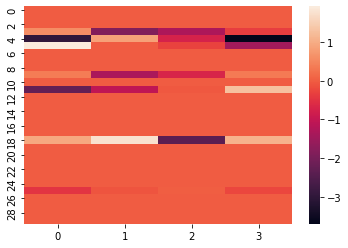

In [72]:
sns.heatmap(beta_optimized)

In [64]:
import cvxpy

In [67]:
# lets try to warm start the optimization from a snootgoose

Help on class Problem in module cvxpy.problems.problem:

class Problem(cvxpy.utilities.canonical.Canonical)
 |  A convex optimization problem.
 |  
 |  Problems are immutable, save for modification through the specification
 |  of :class:`~cvxpy.expressions.constants.parameters.Parameter`
 |  
 |  Arguments
 |  ---------
 |  objective : Minimize or Maximize
 |      The problem's objective.
 |  constraints : list
 |      The constraints on the problem variables.
 |  
 |  Method resolution order:
 |      Problem
 |      cvxpy.utilities.canonical.Canonical
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __add__(self, other) -> 'Problem'
 |  
 |  __div__(self, other) -> 'Problem'
 |  
 |  __init__(self, objective:Union[cvxpy.problems.objective.Minimize, cvxpy.problems.objective.Maximize], constraints:Union[List[cvxpy.constraints.constraint.Constraint], NoneType]=None) -> None
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __mul__(self, other

In [81]:
help(problem.solve)

Help on method solve in module cvxpy.problems.problem:

solve(*args, **kwargs) method of cvxpy.problems.problem.Problem instance
    Compiles and solves the problem using the specified method.
    
    Populates the :code:`status` and :code:`value` attributes on the
    problem object as a side-effect.
    
    Arguments
    ---------
    solver : str, optional
        The solver to use. For example, 'ECOS', 'SCS', or 'OSQP'.
    verbose : bool, optional
        Overrides the default of hiding solver output, and prints
        logging information describing CVXPY's compilation process.
    gp : bool, optional
        If True, parses the problem as a disciplined geometric program
        instead of a disciplined convex program.
    qcp : bool, optional
        If True, parses the problem as a disciplined quasiconvex program
        instead of a disciplined convex program.
    requires_grad : bool, optional
        Makes it possible to compute gradients of a solution with respect to
    

In [83]:
import cvxpy as cp
import numpy as np

# Assuming p and d are defined, and X, y are your data matrices/vectors
# Example dimensions
p, d = 5, 3
X = np.random.randn(10, p)
y = np.random.randn(10, d)

# Create the variable beta
beta = cp.Variable((p, d))

# Define the objective function
objective = cp.Minimize(cp.sum(cp.norm(beta, axis=1)))

# Define the constraints
constraints = [X @ beta == y]

# Define the problem
problem = cp.Problem(objective, constraints)

# Initialize beta with a particular starting point (e.g., a zero matrix or some other point)
initial_value = np.zeros((p, d))  # or some other specific starting point
beta.value = initial_value

# Solver options
scs_opts = {'eps': 1e-12, 'warm_start': True}

# Solve the problem
result = problem.solve(solver=cp.SCS, **scs_opts)

print("Optimal value:", result)
print("Optimal beta:", beta.value)

Optimal value: inf
Optimal beta: None


In [85]:
import cvxpy as cp
import numpy as np

# Assuming p and d are defined, and X, y are your data matrices/vectors
# Example dimensions
p, d = 5, 3
X = np.random.randn(10, p)
y = np.random.randn(10, d)

# Create the variable beta
# beta = cp.Variable((p, d))

# Define the objective function
objective = cp.Minimize(cp.sum(cp.norm(beta, axis=1)))

# Define the constraints
constraints = [X @ beta == y]

# Define the problem
problem = cp.Problem(objective, constraints)

# Initialize beta with a particular starting point (e.g., a zero matrix or some other point)
initial_value = np.zeros((p, d))  # or some other specific starting point
# beta.value = initial_value

# Solver options
scs_opts = {'eps': 1e-12, 'warm_start': False}

# Solve the problem
result = problem.solve(solver=cp.SCS, **scs_opts)

print("Optimal value:", result)
print("Optimal beta:", beta.value)


Optimal value: inf
Optimal beta: None
